In [1]:
%matplotlib inline

In [2]:
!pip install quandl

In [3]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /home/nbuser/anaconda3_501/lib/python3.6/site-packages (19.1.1)


In [4]:
!pip install pandas_datareader

In [5]:
!pip install jupyter_contrib_nbextensions

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import quandl
import pandas as pd
import pandas_datareader 
import datetime
import pandas_datareader.data as web

# Modeling Stock Price Dynamics, using Stochastic Differential Equation

### Author: Yana Stamenova 


### *Abstract*

In this notebook, we built a stochastic differential equation in Python which is commonly used for modeling and predicting asset price dynamics. We explained and built with Python basic concepts such as Random Walk and Wiener process (Brownian motion). These were needed to build our Geometric Brownian Motion model which is one of a few stochastic differential equations that has a closed-form solution. For the exact GBM model, we used Alphabet Inc. (GOOGL) share prices, which we extracted from Quandl. In the end, Euler-Maruyama approximation was used to verify our model against the closed-form solution.  

## Contents:

### *Used Abbreviations*
### *Introduction* 

#### 1. Important deffitions for stocks and financial market
    - Stocks deffinition
    - Efficient Market Hypothesis
    - Stock price process
#### 2. Brownian motion
    2.1 Random Walk
    2.2 Wiener process(Brownian motion)
#### 3. Geometric Brownian Motion (GBM)
    3.1 Euler-Maruyama Approximation
    3.2 Model GBM
#### 4. GBM in Practice
    4.1 GBM model with real data
    4.2 Euler-Maruyama Model
#### 5. Conclusion



### *Used Abbreviations*

- **GBM** - Geometric Brownian Motion 
- **SDEs** - Stochastic differential equations
- **EMH** - Efficient Market Hypothesis 
- **EM** - Euler-Maruyama Model

### *Introduction* 

In order to make investment decisions, simulated price paths of financial assets can be used to make a prediction about the future asset price. 

Simulations of stocks and options are often modeled using stochastic differential equations (SDEs). Unlike deterministic models such as ordinary differential equations, which have a unique solution for each appropriate initial condition, SDEs have solutions that are continuous-time stochastic processes. Methods for the computational solution of stochastic differential equations are based on similar techniques for ordinary differential equations, but generalized to provide support for stochastic dynamics.[<sup>*</sup>](#fn*)

Based on market restrictions and laws, Geometric Brownian Motion is a typical mathematical approach for stock price dynamics modeling. It is a stochastic process, which assumes that the returns, profits or losses, on the stock are independent and normally distributed.

Further, we will model Brownian Motion and then use it to model the closed-form solution of GBM, using Python. Then a comparison will be made between our model and the price dynamics of real stock. We will discuss the limitations of the model and will see if GBM could be used to model approximation of future stock price movements.

#### 1. Important deffitions for stocks and financial market

- **Stock Definition**[<sup>1</sup>](#fn1)

A stock (also known as "shares" or "equity) is a type of security that signifies proportionate ownership in the issuing corporation. Corporations issue (sell) stocks to raise funds to operate their businesses. There are two main types of stock: common and preferred. Stocks are bought and sold predominantly on stock exchanges, though there can be private sales as well and they are the foundation of nearly every portfolio. 
- **Efficient Market Hypothesis (EMH)**[<sup>2</sup>](#fn2)

EMH essentially says that all known(past) information about investment securities, such as stocks, is already factored into the prices of those securities. Therefore, assuming this is true, no amount of analysis can give an investor an edge over other investors, collectively known as "the market".

EMH does not require that investors be rational; it says that individual investors will act **randomly**. As a whole, the market is always "right." In simple terms, "efficient" implies "normal." For example, an unusual reaction to unusual information is normal. If a crowd suddenly starts running in one direction, it's normal for you to run in that direction as well, even if there isn't a rational reason for doing so.

This does not mean that no investors can outperform the market. It means that there are outliers that can beat the market averages, and also outliers that dramatically lose to the market. The majority is closer to the median. 
Those who "win" are lucky and those who "lose" are unlucky. 

Predictions about the stock price movements are uncertain and can only be made in terms of a probability distribution. In this context, modeling a stock price is concerned with modeling the future information, which affects it. Therefore we need two things: 

                                                 - probability distribution and
                                                 - information.


- **Stock price process**

Below we will plot an example of the price of a stock over time. The price behavior resembles the behavior of a process called "Brownian motion". Further, we will explain this process and his derivatives and will use it to model stock price movements. Our experiment will be followed by conclusions about the real-life application of this process to predict future stock price changes. In the example below, we will use the Adjusted Close[<sup>3</sup>](#fn3) price of the stock.

In [7]:
#Extract data for share price of Facebook for a period of 2 years

start = datetime.datetime(2016, 1, 1)
end = datetime.datetime(2018, 1, 1)
facebook = web.DataReader("FB", 'quandl', start, end, access_key = 'XWq2933x7YJEv_XpzmJU')
facebook.head() #shows the first 5 rows by default. 

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2017-12-29,178.00,178.8500,176.46,176.46,10028758.0,0.0,1.0,178.00,178.8500,176.46,176.46,10028758.0
2017-12-28,177.95,178.9367,177.68,177.92,11008996.0,0.0,1.0,177.95,178.9367,177.68,177.92,11008996.0
2017-12-27,176.55,178.4400,176.26,177.62,9296258.0,0.0,1.0,176.55,178.4400,176.26,177.62,9296258.0
2017-12-26,176.63,177.0000,174.67,175.99,8726829.0,0.0,1.0,176.63,177.0000,174.67,175.99,8726829.0
2017-12-22,177.14,177.5300,176.23,177.20,8462491.0,0.0,1.0,177.14,177.5300,176.23,177.20,8462491.0


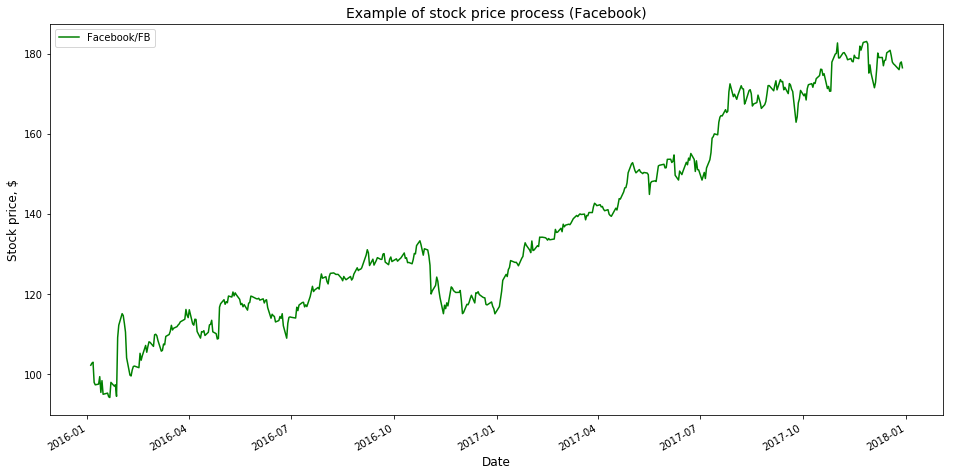

In [8]:
#visualize the data
facebook['AdjClose'].plot(label = 'Facebook/FB', figsize = (16,8), color = "g")
plt.title('Example of stock price process (Facebook)', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Stock price, $', fontsize = 12)
plt.legend(loc = 'upper left') #code for upper left positioning
plt.show()

#### 2. Brownian Motion

    2.1 Random Walk 
A random walk[<sup>4</sup>](#fn4), aka a *"drunkard's walk"* (you may have experienced this after drinking too many tequilas/rakia at a party ;)), is the first step to understanding the Brownian motion. It is a stochastic process, that describes a path that consists of a succession of random steps on some mathematical space such as the integers.
Construction of a random walk consists of the following rules:
For an integer n, n>0, we define the Random Walk process at the time $\mathit t $ {$ \mathit W_n(t) > 0 $} as follows:
1. The initial value of the process is: $ \mathit W_n(0) = 0 $
2. The layer spacing between two successive jumps is equal to $ \mathit 1/n $
3. The "up" and "down" jumps are equal and of size $ \mathit 1/\sqrt{n}$, with equal probability.

    An elementary example of a random walk is the random walk on the integer number line, which starts at 0 and at each step moves +1 or -1 with equal probability. We can express this process mathematically. Lets $ \mathit x_n $ is the "walkers" position at time $ \mathit n $. This position is an evolution from a moment before - $ \mathit n - 1 $, obtained by adding a random variable $ \mathit s $ to the previous position $ \mathit x_{n-1} $. The probabilities for moving upwards(+1) or backwards (-1) are as follows: $ \mathit P(s = 1) = 1/2 $ and $ \mathit P(s = -1) = 1/2 $. So now, the next step can be expressed mathematically:
    
    $$\mathit x_n = x_{n-1} + s, \quad x_0 = 0, \quad P(s = 1) = P(s = -1) = 1/2$$
    
We implement an example of a simple 1-D random walk below.

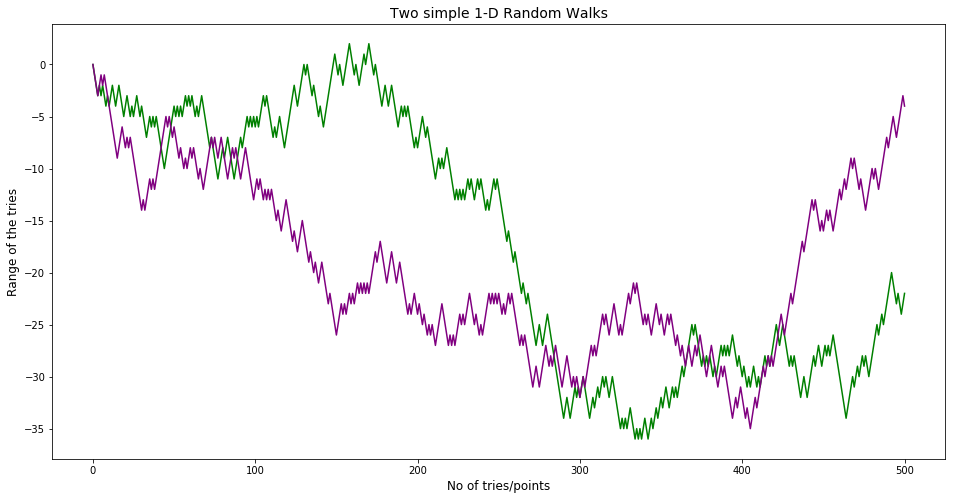

In [9]:
#We will visualize two simple 1D random walks where "the walker" can move either "up or down the road". 
#The probability to make step up or down is equal
prob = [0.5, 0.5]

steps = 500  
 
#Define the random walk function with steps count and probabilities for up and down 

def SimpleRandomWalk(N, p1, p2, color):
    
    #statically defining the starting position
    start = 0
    positions = [start]
    
    #creating random points between 0 and 1 / the steps
    rand_p = np.random.random(steps)
    
    #creating lists of steps for both directions
    down_p = rand_p < prob[0]
    up_p = rand_p > prob[1]

    for down, up in zip(down_p, up_p): #the random walk process
        if down == 1 and up == 0:
            movement = -1  
        elif down == 0 and up == 1:
            movement = 1
        positions.append(positions[-1] + movement) #[-1] takes the last element, since the next move depends on it
        
    plt.plot(positions, color)
    plt.title('Two simple 1-D Random Walks', fontsize = 14)
    plt.xlabel('No of tries/points', fontsize = 12)
    plt.ylabel('Range of the tries', fontsize = 12)
    
    return None

        

plt.figure(figsize = (16, 8))



SimpleRandomWalk(steps, prob[0], prob[1], color = "green")

SimpleRandomWalk(steps, prob[0], prob[1], color = "purple")
plt.show()


    2.2 Wiener process(Brownian motion)

Before we can model the GBM, we need to first explain and model the Brownian Motion, which is the stochastic portion of the GBM equation.

In mathematics, the **Wiener process** is a continuous-time stochastic process named in honor of Norbert Wiener[<sup>5</sup>](#fn5). It is often called standard Brownian motion process or Brownian motion due to its historical connection with the physical process known as Brownian motion originally observed by Robert Brown. 

The Wiener process $ \mathit W_t $ is characterised by the following properties:
1. $ \mathit {W_0} = 0 $ a.s.[<sup>6</sup>](#fn6)
2. $ \mathit {W} $ has independent increments: for every $\mathit t > 0 $, the future increments $ \mathit {W_{t+u}-W_t}, \hspace{0.1cm} {u >= 0} $, are independent of the past walues $ \mathit {W_s}, \hspace{0.1cm} s > t $.
3. $ \mathit {W} $ has Gaussian increments: $ \mathit {W_{t+u} - W_t} $ is normally distributed with mean 0 and variance $ \mathit {u}, \hspace{0.1cm} {W_{t+u} - W_t} ~ N(0, u) $.
4. $ \mathit {W} $ has continuous paths: With probability 1, $ \mathit W_t $ is continuous in $ \mathit t $.

The process has independent increments means that if $\mathit 0 <= s_1 < t_1 <= s_2 < t_2 $ then $\mathit W_{t_1} - W_{s_1}$ and $\mathit W_{t_2} - W_{s_2}$ are independent random variables, and the similar condition holds for $\mathit n $ increments.

To simulate single Brownian increment $\mathit W_i $ at one fixed time increment is computed by multiplying a standard random variable $\mathit z_i $ from a normal distribution $\mathit N(0, 1)$ with mean **0** and standard deviation **1** by the square root of the time increment $\mathit {\sqrt {\Delta t_i}}$:

\begin{equation*}
\mathit \Delta W_i = z_i{\sqrt {\Delta t_i}} \tag{1} \label{eq:special}
\end{equation*} 

The cumulative sum of the Brownian increments is the discretized Brownian path.
\begin{equation*}
\mathit W_n(t) = \sum_{i=1}^n{W_i(t)} \tag{2} \label{eq:special}
\end{equation*}
Below we will model Brownian Motion. First, we need to generate standard random variables from the normal distribution $\mathit N(0, 1)$. Then we will multiply them by the square root of the time step. Finally, we will compute their cumulative sum and generate the Brownian Motion.

In [10]:
T = 1.        #time interval
N = 250        #number of points


seed = 20

dt = T / N                 #time step
t = np.arange(0.0, 1.0, dt)

def BrownianMotion(seed, N):
    
    np.random.seed(seed)

    Z = np.random.randn(N)     #random variables
    Z[0] = 0
    
    dW = np.sqrt(dt)* Z        #single Brownian increment
    
    W = np.cumsum(dW)          #Brownian path
    
    return W

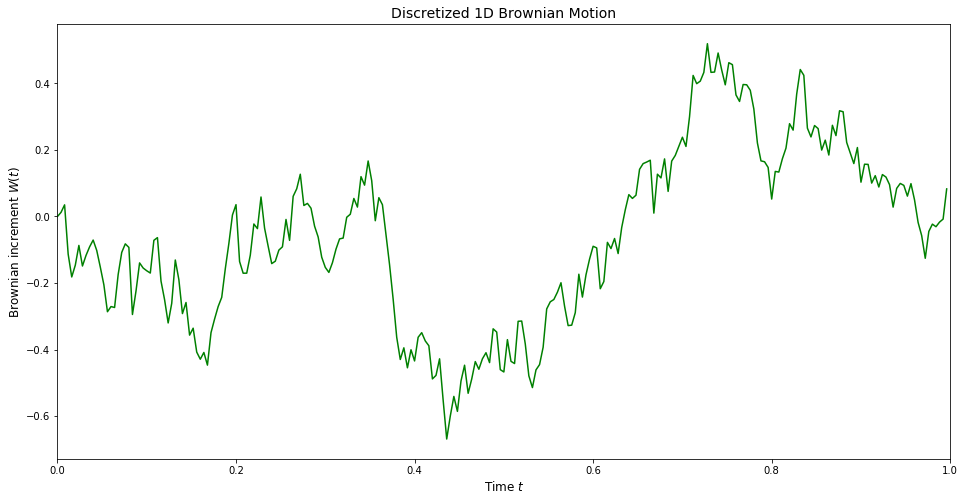

In [11]:
W = BrownianMotion(seed, N)

plt.figure(figsize = (16, 8))
plt.plot(t, W, color = "green")
plt.title('Discretized 1D Brownian Motion', fontsize = 14)
plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('Brownian increment $W(t)$', fontsize = 12)
axes = plt.gca()
axes.set_xlim([0,T])
plt.show()

As we can see the plot of the Brownian Motion shows a path that looks similar to the movement of a stock price.

#### 3. Geometric Brownian Motion (GBM)

Simulations of stocks and options are often modeled using stochastic differential equations (SDEs). 
A typical model used for stock price dynamics is the Black-Scholes diffusion equation:

\begin{equation*}
\mathbf {dS_t} = \mu S_t \hspace{0.1cm} dt +  \sigma S_t \hspace{0.1cm} dW_t \tag{3} \label{eq:special}
\end{equation*} where,
   - $ \mathbf S $ is the *stock price*, 
   - $ \mathbf \mu $ is the *drift coefficient* (the mean of returns over some time period), 
   - $ \mathbf \sigma $ is the *diffusion coefficient* (standard deviation of the returns), and
   - $ \mathit W_t $ is the *Wiener process (Brownian motion)*.

Coefficients $\mathit \mu$ and $\mathit \sigma$ are both *constant* in this model. In more sophisticated models they can be made to be functions of $\mathit t, S_t$ and other stochastic processes.

As we can see SDEs have both deterministic(drift) component and stochastic(diffusion) component $\mathit W_t$. The latter was calculated and visualized in the previous section. 
For the SDE above, with an initial condition for the stock price of $\mathit S(0) = S_0 $, the closed-form solution of GBM is:

\begin{equation*}
\mathit \textstyle S(t) = S_0e^{(\mu - \frac {1}{2}\sigma^2)t+\sigma{W_t}} \tag{4} \label{eq:special} 
\end{equation*}

This solution is solved using the Itô interpretation[<sup>7</sup>](#fn7) (which we will not derive in this notebook). Very few SDEs actually have closed-form solutions. For the ones that don't, we need to use numerical approximation techniques.


    3.1 Euler-Maruyama Approximation

The Euler-Maruyama Method (EM) is a method for simulating the solutions of a SDE[<sup>8</sup>](#fn8). The example in the previous section is a simple case where there's a closed-form solution of the stochastic differential equation. The EM generates a stochastic process path approximation. 

To develop an approximate solution on the interval $\mathit [c,d]$, we assign a grid of points[<sup>*</sup>](#fn*):
$$\mathit c = t_o < t_1 < t_2 < ... < t_n = d $$
Approximate $\mathit s$ values
$$\mathit w_o < w_1 < w_2 < ... < w_n$$
will be determined at the respective $\mathit t$ points. 

Given equation (3) we can compute the approximate solution of Black-Scholes SDE with EM:

\begin{equation*}
w_0 = S_0
\end{equation*}

\begin{equation*}
w_{i+1} = w_i + \mu w_i \Delta t_i + \sigma w_i \Delta W_i  \tag{5} \label{eq:special} 
\end{equation*}

Each random increment is computed as shown in equation (1). Each set of $\mathit {w_0,...,w_n}$, produced by the EM is an approximate realization of the solution stochastic process $\mathit S(t)$. The latter depends on the random numbers $\mathit z_i$. Given that $\mathit W_t$ is a stochastic process, each realization will be different and so will our approximations.  

We are going to use the EM approximation as a verification of our model by comparing it to the closed-form solution. The purpose of comparing if the results are similar to the closed-form solution is to check if we are solving the mathematical model correctly. 

Further, we will build a GBM model with assumed values of $\mathit \mu$, $\mathit \sigma$, and initial stock price $\mathit S_0$. Then we will use this GBM model to see how it works for real stocks. Finally, we will build an EM to approximate a stock price path and make conclusions about the GBM model.

    3.2 Model GBM

In [12]:
#Constructing GBM

# Parameters:
# So - initial stock price = 56.23
# mu - the mean of returns = 0.2
# sigma - standard deviation of returns (volatility) = 0.45
# W - Brownian motion/stochastic part
# T - time horizon
# N - number of intervals
# We are using equation (4)

def GBM(So, mu, sigma, W, N, t):
    
    S = []
    S.append(So)
          
    for i in range(1,N):
        drift = (mu - 0.5 * sigma**2) *t[i]       #Calculating the deterministic part
        diffusion = sigma * W[i-1]                #Calculating the stochastic part
        S_i = So * np.exp(drift + diffusion)
        S.append(S_i)
        
    return S

So = 56.23
mu = 0.15
sigma = 0.6
W = BrownianMotion(seed, N)
N = 250     #assume 250 trading days for one year   
T = 1.0        

t = np.linspace(0., T, N)    #time increments


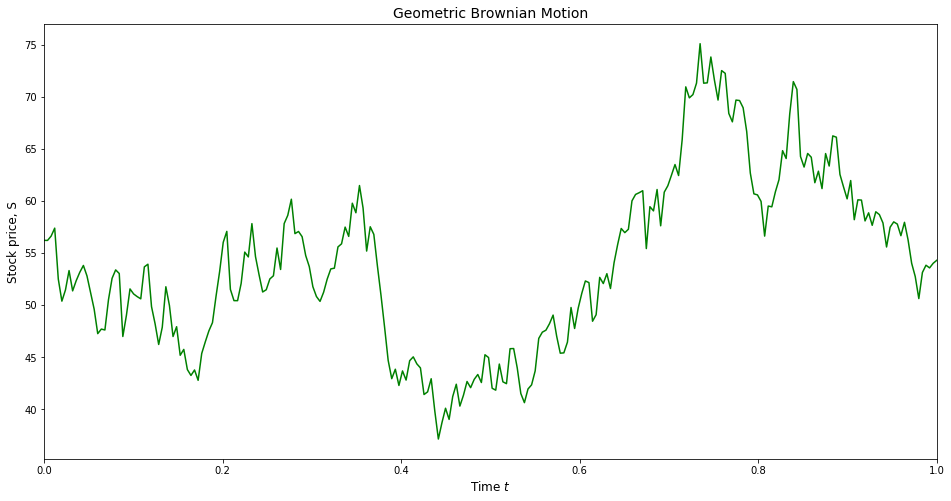

In [13]:
#plot solution

solution = GBM(So, mu, sigma, W, N, t)

plt.figure(figsize = (16, 8))
plt.plot(t, solution, color = "green")

#plt.scatter(t, solution, color = "black")
plt.title('Geometric Brownian Motion', fontsize = 14)
plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('Stock price, S', fontsize = 12)
axes = plt.gca()
axes.set_xlim([0,T])
plt.show()

When we look at the plot, it reminds us of the typical stock price movement. The axis represents a full trading year with 250 trading days. It is important to keep in mind that in the beginning when we constructed the Brownian Motion, we set a seed = 15. If we change the seed the path will change too. We will show this further. The model is also extremely simplified. We don't take into account severe "shocks". Major news could change the volatility significantly which will lead to change in the movement of the stock price.

#### 4. GBM in Practice    

In this section, we will apply the GBM for the shares of Alphabet (GOOGL) and compare it to the actual stock prices. We will use data for the daily returns of Alphabet for 2017. Our model will be built for a one-year time horizon.

We will use [Quandl](https://www.quandl.com/) as a source of our price data. Below we will show part of the data to be sure we are using the right information. Then we will use the adjusted closing prices for plotting since they are a more accurate representation of the price value of the stocks (see footnote 3). 

In [14]:
start = datetime.datetime(2017, 1, 1)
end = datetime.datetime(2018, 1, 1)
google = web.DataReader("GOOGL", 'quandl', start, end, access_key = 'XWq2933x7YJEv_XpzmJU')
google.head() 

,Open,High,Low,Close,Volume,ExDividend,SplitRatio,AdjOpen,AdjHigh,AdjLow,AdjClose,AdjVolume
Date,,,,,,,,,,,,
2017-12-29,1055.49,1058.05,1052.70,1053.40,1156357.0,0.0,1.0,1055.49,1058.05,1052.70,1053.40,1156357.0
2017-12-28,1062.25,1064.84,1053.38,1055.95,982285.0,0.0,1.0,1062.25,1064.84,1053.38,1055.95,982285.0
2017-12-27,1066.60,1068.27,1058.38,1060.20,1027634.0,0.0,1.0,1066.60,1068.27,1058.38,1060.20,1027634.0
2017-12-26,1068.64,1068.86,1058.64,1065.85,914574.0,0.0,1.0,1068.64,1068.86,1058.64,1065.85,914574.0
2017-12-22,1070.00,1071.72,1067.64,1068.86,860800.0,0.0,1.0,1070.00,1071.72,1067.64,1068.86,860800.0


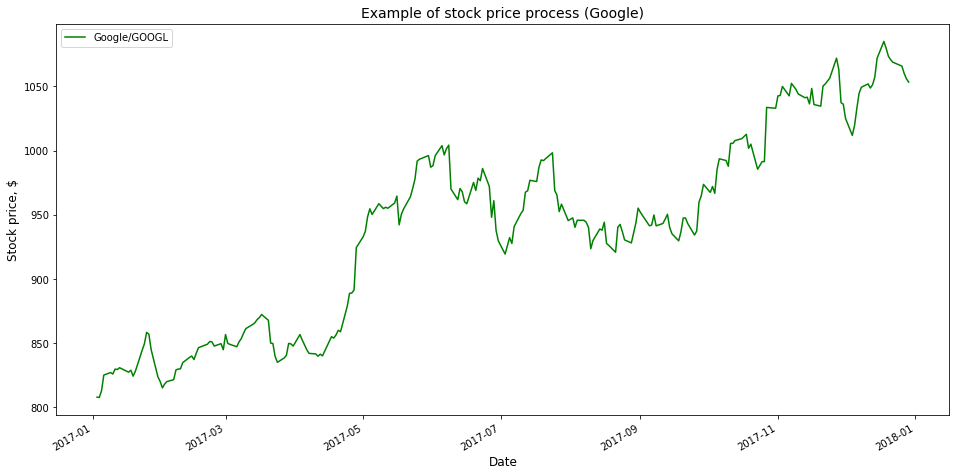

In [15]:
adj_close = google['AdjClose']
adj_close.plot(label = 'Google/GOOGL', figsize = (16,8), color = "g")
plt.title('Example of stock price process (Google)', fontsize = 14)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Stock price, $', fontsize = 12)
plt.legend(loc = 'upper left') 
plt.show()

You can compare this plot with the correct chart [here](https://finance.yahoo.com/quote/GOOGL/chart?p=GOOGL#eyJpbnRlcnZhbCI6ImRheSIsInBlcmlvZGljaXR5IjoxLCJjYW5kbGVXaWR0aCI6My44NjQ1NDE4MzI2NjkzMjMsInZvbHVtZVVuZGVybGF5Ijp0cnVlLCJhZGoiOnRydWUsImNyb3NzaGFpciI6dHJ1ZSwiY2hhcnRUeXBlIjoibGluZSIsImV4dGVuZGVkIjpmYWxzZSwibWFya2V0U2Vzc2lvbnMiOnt9LCJhZ2dyZWdhdGlvblR5cGUiOiJvaGxjIiwiY2hhcnRTY2FsZSI6ImxpbmVhciIsInBhbmVscyI6eyJjaGFydCI6eyJwZXJjZW50IjoxLCJkaXNwbGF5IjoiR09PR0wiLCJjaGFydE5hbWUiOiJjaGFydCIsInRvcCI6MH19LCJsaW5lV2lkdGgiOjIsInN0cmlwZWRCYWNrZ3JvdWQiOnRydWUsImV2ZW50cyI6dHJ1ZSwiY29sb3IiOiIjMDA4MWYyIiwiZXZlbnRNYXAiOnsiY29ycG9yYXRlIjp7ImRpdnMiOnRydWUsInNwbGl0cyI6dHJ1ZX0sInNpZ0RldiI6e319LCJyYW5nZSI6eyJkdExlZnQiOiIyMDE2LTEyLTMxVDIyOjAwOjAwLjAwMFoiLCJkdFJpZ2h0IjoiMjAxNy0xMi0zMVQyMjowMDowMC4wMDBaIiwicGVyaW9kaWNpdHkiOnsiaW50ZXJ2YWwiOiJkYXkiLCJwZXJpb2QiOjF9LCJwYWRkaW5nIjowfSwiY3VzdG9tUmFuZ2UiOnsic3RhcnQiOjE0ODMzOTQ0MDAwMDAsImVuZCI6MTUxNDQ5ODQwMDAwMH0sInN5bWJvbHMiOlt7InN5bWJvbCI6IkdPT0dMIiwic3ltYm9sT2JqZWN0Ijp7InN5bWJvbCI6IkdPT0dMIn0sInBlcmlvZGljaXR5IjoxLCJpbnRlcnZhbCI6ImRheSJ9XSwic3R1ZGllcyI6eyJ2b2wgdW5kciI6eyJ0eXBlIjoidm9sIHVuZHIiLCJpbnB1dHMiOnsiaWQiOiJ2b2wgdW5kciIsImRpc3BsYXkiOiJ2b2wgdW5kciJ9LCJvdXRwdXRzIjp7IlVwIFZvbHVtZSI6IiMwMGIwNjEiLCJEb3duIFZvbHVtZSI6IiNGRjMzM0EifSwicGFuZWwiOiJjaGFydCIsInBhcmFtZXRlcnMiOnsid2lkdGhGYWN0b3IiOjAuNDUsImNoYXJ0TmFtZSI6ImNoYXJ0In19fX0%3D)

    4.1 GBM with real data

This time we will not assume $\mathit \mu$ and $\mathit \sigma$. We will compute their values from the data that we have. Let's start with calculating the daily returns:

In [16]:
# Stock Return (excl. dividents) = (P1 - P0)/P0, where P0 = Initial Stock Price, P1 = Ending Stock Price (Period 1)
adj_reversed = list(reversed(adj_close))

def daily_return(adj_reversed):
    returns = []
    for i in range(0, len(adj_reversed)-1):
        today = adj_reversed[i+1]
        yesterday = adj_reversed[i]
        
        daily_return = (today - yesterday)/yesterday
        
        returns.append(daily_return)
    return returns      

returns = daily_return(adj_reversed)


In [17]:
#compute the drift(mean) and diffusion(variance) coefficients and annualize it by multiplying by 250 trading days 
mu = np.mean(returns) * 250.            
sig = np.std(returns)* np.sqrt(250.)

print(mu)
print(sig)

0.27781278325588427
0.1510608270308626


Assuming constant drift and volatility throughout a longer time period is not realistic. This is why the model was created only for one year period(which is not too short but it is not too long period either). 
Now that we have computed the drift and diffusion coefficients, it is time to build the GBM function of the Alphabet stock. We will base it on equation (4) where we actually have an exact solution. 

In [18]:
#GBM based on real stock prices

# Parameters:
# So - initial stock price 
# mu - the mean of returns 
# sigma - standard deviation of returns (volatility)
# W - Brownian motion
# T - time horizon
# N - number of intervals

def GBM_Exact(So, mu, sigma, W, N, t):
    
    S = []
    S.append(So)
          
    for i in range(1,N):
        drift = (mu - 0.5 * sigma**2) *t[i]       #Calculating the deterministic part
        diffusion = sigma * W[i-1]                #Calculating the stochastic part
        S_i = So * np.exp(drift + diffusion)
        S.append(S_i)
        
    return S


So = adj_reversed[0]
W = BrownianMotion(seed, N)
N = 250     #assume 250 trading days for one year   
T = 1.0        

t = np.linspace(0., T, N)    #time increments

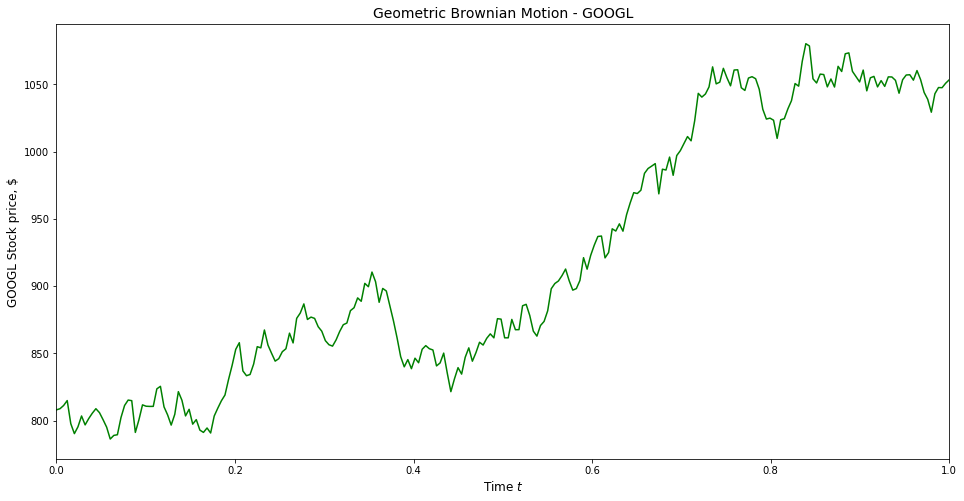

In [19]:
#plot solution

solution = GBM_Exact(So, mu, sig, W, N, t)

plt.figure(figsize = (16, 8))
plt.plot(t, solution, color = "green")

#plt.scatter(t, solution, color = "black")
plt.title('Geometric Brownian Motion - GOOGL', fontsize = 14)
plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('GOOGL Stock price, $', fontsize = 12)

axes = plt.gca()
axes.set_xlim([0,T])
plt.show()

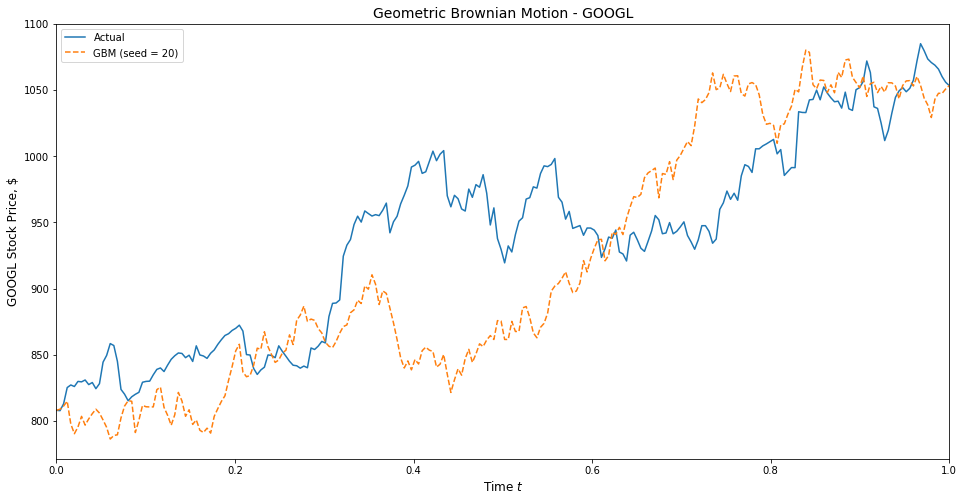

In [20]:
plt.figure(figsize = (16, 8))


plt.plot(t, adj_reversed, label = 'Actual')
plt.plot(t, solution, label = 'GBM (seed = 20)', ls='--')

plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('GOOGL Stock Price, $', fontsize = 12)
plt.title('Geometric Brownian Motion - GOOGL', fontsize = 14)

plt.legend(loc = 'upper left')
axes = plt.gca()
axes.set_xlim([0,T])
plt.show()

Now let's plot the GBM models with different random seeds to see how the path changes. Again we will compare it with the actual GOOGL stock price. 

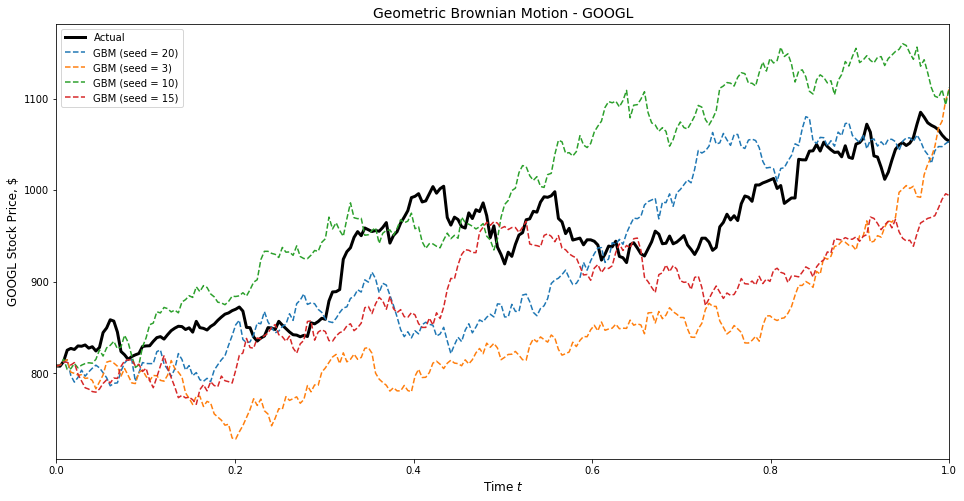

In [21]:
N =250
So = adj_reversed[0]

seed = 3
W = BrownianMotion(seed, N)
solution2 = GBM_Exact(So, mu, sig, W, N, t)

seed = 10
W = BrownianMotion(seed, N)
solution3 = GBM_Exact(So, mu, sig, W, N, t)

seed = 15
W = BrownianMotion(seed, N)
solution4 = GBM_Exact(So, mu, sig, W, N, t)


plt.figure(figsize = (16, 8))


plt.plot(t, adj_reversed, label = 'Actual', linewidth = 3, color = "black")
plt.plot(t, solution, label = 'GBM (seed = 20)', ls='--')
plt.plot(t, solution2, label = 'GBM (seed = 3)', ls='--')
plt.plot(t, solution3, label = 'GBM (seed = 10)', ls='--')
plt.plot(t, solution4, label = 'GBM (seed = 15)', ls='--')


plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('GOOGL Stock Price, $', fontsize = 12)
plt.title('Geometric Brownian Motion - GOOGL', fontsize = 14)

plt.legend(loc = 'upper left')
axes = plt.gca()
axes.set_xlim([0,1.])
plt.show()

What we can see is that depending on the random numbers that are being generated, the path changes its shape. With more simulations we will be able to tell how well our model is able to generalize. Below we will make 100 simulations. 

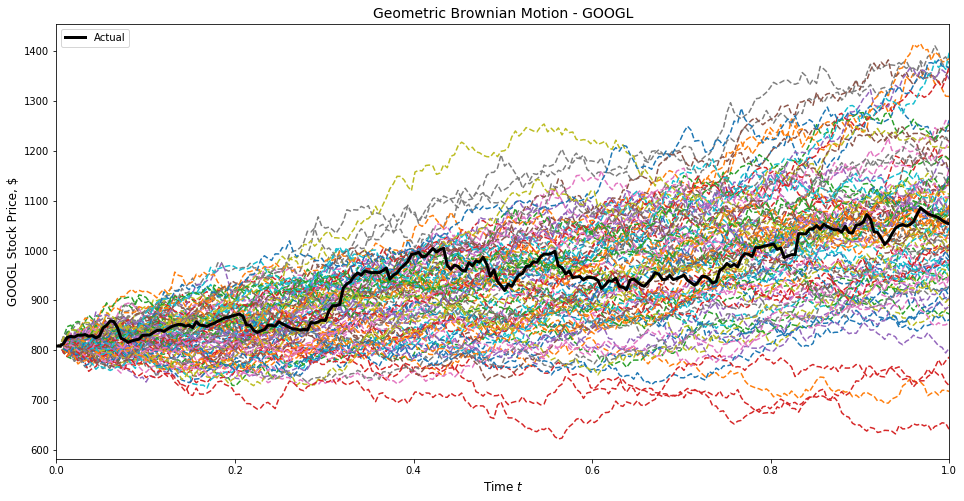

In [22]:
T=1.
N = 250
So = adj_reversed[0]

plt.figure(figsize = (16, 8))

for seed in range(1, 100):   
    W = BrownianMotion(seed, N)  
    solution = GBM_Exact(So, mu, sig, W, N, t)
    plt.plot(t, solution, ls='--')
    
plt.plot(t, adj_reversed, label = 'Actual', color = "black", linewidth = 3)
plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('GOOGL Stock Price, $', fontsize = 12)
plt.title('Geometric Brownian Motion - GOOGL', fontsize = 14)

plt.legend(loc = 'upper left')
axes = plt.gca()
axes.set_xlim([0,T])

plt.show()

    4.2 Euler-Maruyama Model

Now that we see that our GBM model is working, we will build the EM model to approximate a path. We did not try to fit the model to any path since this could lead to overfitting[<sup>9</sup>](#fn9), lead to errors and reduce the predictive power of our model.

We will use a seed = 20 and equation (5).

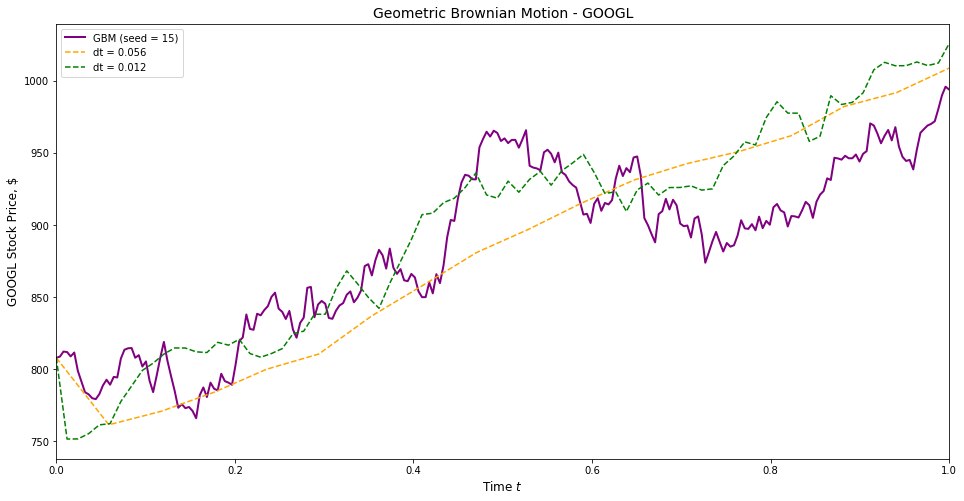

In [23]:
# Parameters:
# So - initial stock price 
# mu - annualized mean of returns 
# sigma - standard deviation of returns (volatility)
# W - Brownian motion
# T - time horizon
# N - number of intervals
# TS - time step


#GBM - GOOGL
T=1.
N = 250
So = adj_reversed[0]  #adj. close price of GOOGL as of January 3rd, 2017 

seed = 15
W = BrownianMotion(seed, N)
solution = GBM_Exact(So, mu, sig, W, N, t)  #exact solution
t = np.linspace(0., 1., N)    #time increments

plt.figure(figsize = (16, 8))

plt.plot(t, solution, label = 'GBM (seed = 15)', color = "purple", linewidth = 2)



#Euler Maruyama Approximation

    
def Em(So, mu, sigma, b, T, N, TS):
    dt = TS * (1./N)                            # EM step size
    L = N / TS                              # intervals according to the TS
    wi = []
    wi.append(So)
    for i in range (0, int(L)):
        delta_Wi = b[i-1] - b[i]
        wi_new = wi[i] + mu * wi[i] * dt + sigma *wi[i] * delta_Wi
        wi.append(wi_new)
    return wi, dt




#Different time step sizes


b = BrownianMotion(seed, N)
TS = 14
L = N/TS
Approx_1 = Em(So, mu, sig, W, T, N, TS)[0]
time_Em_1 = np.linspace(0., 1., int(L+1))
dt_1 = Em(So, mu, sig, W, T, N, TS)[1] #0.056

b = BrownianMotion(seed, N)
TS = 3
L = N/TS
Approx_2 = Em(So, mu, sig, W, T, N, TS)[0]
time_Em_2 = np.linspace(0., 1., int(L+1))
dt_2 = Em(So, mu, sig, W, T, N, TS)[1] #0.012

plt.plot(time_Em_1, Approx_1, label = 'dt = 0.056', color = "orange", ls = '--')
plt.plot(time_Em_2, Approx_2, label = 'dt = 0.012', color = "green", ls = '--')


plt.xlabel('Time $t$', fontsize = 12)
plt.ylabel('GOOGL Stock Price, $', fontsize = 12)
plt.title('Geometric Brownian Motion - GOOGL', fontsize = 14)

plt.legend(loc = 'upper left')
axes = plt.gca()
axes.set_xlim([0,T])
plt.show()

#### 5. Conclusion
Our results show that if we choose a smaller time step the EM model better approximates the sollution. When we increase the time step we still follow the trend but the sharp movements (changes in the price dynamics and direction) are not detected.   
As we have already mentioned the biggest limitation to the simulation is the assumption that the drift and volatility are constant over time. This would be more visible if we had chosen bigger time period.

### Footnotes

<span id="fn*"> ** *: ** [SDEs](http://math.gmu.edu/~tsauer/pre/sde.pdf) </span>

<span id="fn1"> **1. Stock Definition:** [Investopedia](https://www.investopedia.com/terms/s/stock.asp) </span>

<span id="fn2"> **2. EMS:** [TheBalance.com](https://www.thebalance.com/efficient-markets-hypothesis-emh-2466619) </span>

<span id="fn3"> **3. **[**Adj. Close:**](https://budgeting.thenest.com/adjusted-closing-price-vs-closing-price-32457.html) - *The closing price of a stock is the price of that stock at the close of the trading day. The adjusted closing price is a more complex analysis that uses the closing price as a starting point, but it takes into account factors such as dividends, stock splits and new stock offerings to determine a value. The adjusted closing price represents a more accurate reflection of a stock's value, since distributions and new offerings can alter the closing price.* </span>

<span id="fn4"> **4.** Dmouj, Abdelmoula; **"Stock price modelling: Theory and Practice"**, 2.4 Random Walk, pg. 10, Vrije Universiteit, Faculty of sciences Amsterdam, The Netherlands</span>

<span id="fn5"> **5. Wiener process:** [Wikipedia](https://en.wikipedia.org/wiki/Wiener_process) </span>

<span id="fn6"> **6. a.s.:** An event happens almost surely if it happens with probability one. In other words, the set of possible exceptions may be non-empty, but it has probability zero.  </span>

<span id="fn7"> **7. Itô calculus:** [Wikipedia](https://en.wikipedia.org/wiki/It%C3%B4_calculus) </span>

<span id="fn8"> **8. Euler-Maruyama method:** Dunbar, Steven R.;[Stochastic Processes and Advanced Mathematical Finance](http://www.math.unl.edu/~sdunbar1/MathematicalFinance/Lessons/StochasticCalculus/StochasticDEs/stochasticdes.pdf), University of Nebraska-Lincoln </span>

<span id="fn9"> **9. Overfitting:** [Investopedia](https://www.investopedia.com/terms/o/overfitting.asp) </span>


### References
1. This notebook is created on the base of this work - Github: Sullivan, John, [Stochastic Calculus with Python: Simulating Stock Price Dynamics](https://jtsulliv.github.io/stock-movement/) 
2. [Simulating Brownian motion (BM) and geometric Brownian motion (GBM)](http://www.columbia.edu/~ks20/4404-Sigman/4404-Notes-sim-BM.pdf), Copyright 2013 by Karl Sigman
3. Quantopian: [Learning SDEs in Python](https://www.quantopian.com/posts/learning-sdes-in-python)
4. Quantstart: [Geometric Brownian Motion](https://www.quantstart.com/articles/Geometric-Brownian-Motion)
